In [1]:
# Libraries
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import linalg
from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
import scipy.fft as fft
import scipy.signal as signal
from sklearn.pipeline import Pipeline
from pprint import pprint
from datetime import datetime
from scipy.signal import find_peaks
import pywt
from scipy import stats
import matplotlib.mlab as mlab

# Project Outline
1. Explaining Dataset
2. Calibrate the data
3. Clean the data (and why we clean the data)
4. Plot the calibrate data
5. Statistical Description
6. PCA, why we do it and results
7. Check the PCA 
8. Discrete Fourier + Filter (normal + gaussian)
9. Wavelet + filter
10. Alternative Method
11. Results BPM from differents method + variability
12. What is the best method and why

# Discrete Fourier Transform

## Analyzing the Peaks

After having applied the {Gaussian / Passband} filter we apply the inverse fourier transform and then analyze the peaks to find the BPM.  We can use the data transformed with the PCA method.

In [ ]:
for i in np.arange(inverse_fft_signal.shape[1]):
    PlotPeak_and_Histogram(feature)

# Alternative Method
## Data Composition

We also implemented another method to extrapolate the BPM from the data, using the fact that heart movement cause both a high linear and angular acceleration. We can see from the data that bot "Acc" and "Gyro" feature are composed of a low frequency component convoluted with a higher frequency component.
## Subtracting the Baseline
First we subtract the baseline low frequency component from a feature (here we use "GyroX" as an example, but we can use this method with all features).

NameError: name 'cleaned_data' is not defined

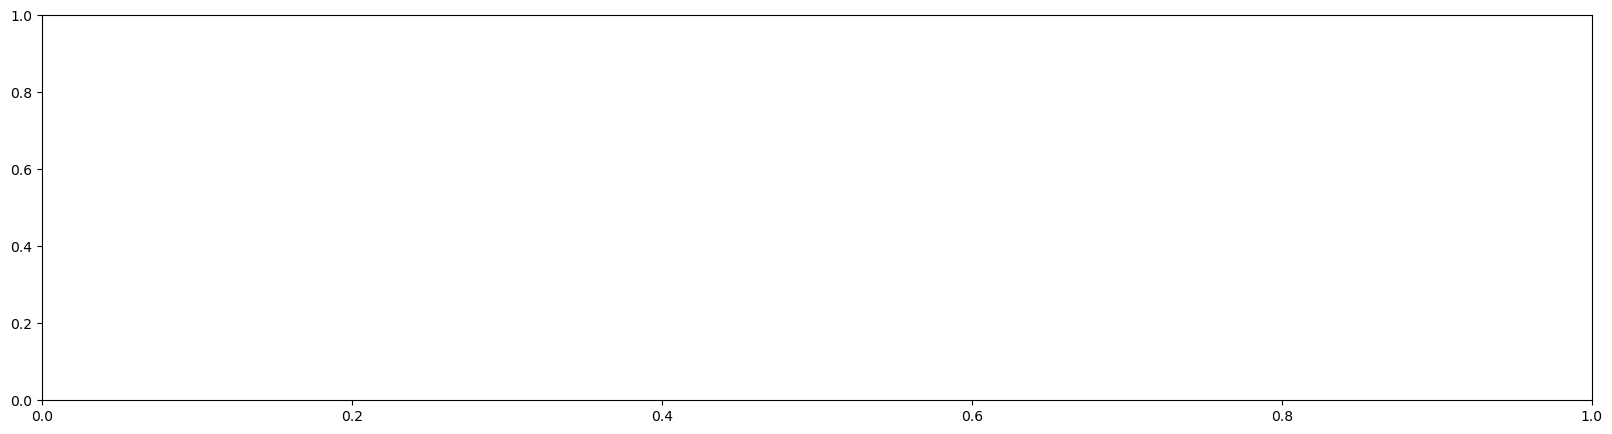

In [3]:
# Given that "cleaned_data" si the trucnated data

# Plot the data to showcase the low and high frequency component, using "GyroX" time-series as an example

fig, ax = plt.subplots(figsize=(20,5))
ax.plot(cleaned_data["Time"].values, cleaned_data["GyroX"].values)
ax.set_title("GyroX in function of time")
ax.set_ylabel("GyroX")
ax.set_xlabel("Time")

## Finding the peaks
We can see that the data is characterized by a higher frequency component. We can analyze it's peaks to extrapolate the it's frequency.
First, we euristically determine a thresold to isolate the peaks, and take care to count only one peak per beat (heart beat has a two peak frequency), as seen in the plot above.
We can also, after having isolated the peaks, plot the histogram of the inverse periods (so the frequencies) of the individual peaks.

In [4]:
# Plot the peaks and the hsitogram of the frequency, and calculate the important values (for the main dataset)
PlotPeak_and_Histogram(cleaned_data["GyroX"],ht=4,lt=-4,plot=True,mean_frequency=mean_frequency);

NameError: name 'cleaned_data' is not defined

This method is useful in the way that is robust against noise and setup, but the threshold must be set according to the real-world setup and the physics involved in the data acquisition. The same amplitude cannot be shared among datasets as the maximum amplitude changes according to the position of the subject. After analyzing the dataset, a reasonable threshold can be set and the analysis subsequently performed.
As seen here, we can estimate a BPM of {BPM} from the "GyroX" feature, and a similar estimate (with different threshold) can be obtained.


## Results


# Helper Functions

In [5]:
# Helper Functions

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

def Peaks(time_series,window=50,ht = 0.5, lt = -0.5,min_dis = 80,ax = False,plot=False,mean_frequency = 200):
    """Function to extrapolate the peaks from a time series, and optionally plot them"""
    
    time_series = time_series.values # Get only the numpy array
    moving_mean = running_mean(time_series,window) # Calculate moving average
    time_series = (time_series[int(window/2)-1:-int(window/2)] - moving_mean) # Subtract moving average from dataset
    minima_index, _ = signal.find_peaks(-time_series,-lt,distance=min_dis) # Find minima
    BPM_low = minima_index.shape[0]/(time_series.shape[0]/mean_frequency)*60 # Calculate mean BPM from minima
    maxima_index, _ = signal.find_peaks(time_series,ht,distance=min_dis) # Find maxima
    BPM_high = maxima_index.shape[0]/(time_series.shape[0]/mean_frequency)*60 # Calculate mean BPM from maxima
    
    if plot:
        if ax:
            pass
        else:
            fig, ax = plt.subplots(figsize=(20,5))
        ax.set_xlabel("Time in Sample Number")
        ax.set_ylabel("Distance from Moving Average")
        ax.plot(time_series)
        ax.hlines(lt,0,time_series.shape[0])
        ax.scatter(minima_index, time_series[minima_index],c = "red",s=10)
        ax.hlines(ht,0,time_series.shape[0])
        ax.scatter(maxima_index, time_series[maxima_index],c = "red",s=10)

    print("Estimated BPM from lower peaks: ", int(BPM_low))
    print("Estimated BPM from higher peaks: ", int(BPM_high))
    print("Estimated Mean BPM from peaks: ", int((BPM_low + BPM_high)/2))
    return (BPM_low, BPM_high)

def PeaksHist(time_series,window=50,ht = 0.5, lt = -0.5,min_dis = 80,ax = False,plot=False,mean_frequency = 200):

    time_series = time_series.values  # Get only the numpy array
    moving_mean = running_mean(time_series,window) # Calculate moving average
    time_series = (time_series[int(window/2)-1:-int(window/2)] - moving_mean) # Subtract moving average from dataset
    minima_index, _ = signal.find_peaks(-time_series,-lt,distance=min_dis) # Find minima
    BPM_low = minima_index.shape[0]/(time_series.shape[0]/mean_frequency)*60 # Calculate mean BPM from minima
    maxima_index, _ = signal.find_peaks(time_series,ht,distance=min_dis) # Find maxima
    BPM_high = maxima_index.shape[0]/(time_series.shape[0]/mean_frequency)*60 # Calculate mean BPM from maxima
    BPM = mean_frequency/np.array([maxima_index[i] - maxima_index[i-1] for i in range(1,len(maxima_index))])*60 # Calculate BPM from periods
    (mu,sigma) = stats.norm.fit(BPM) # Fit a gaussian to the periods
    print(f"Mean BPM from histogram: {round(mu,2)}, Standard Deviation: {round(sigma,2)}")
    
    if plot:
        if ax:
            pass
        else:
            fig, ax = plt.subplots(figsize=(20,5))
        

        h = np.histogram(BPM,bins=30)
        width=h[1][1] - h[1][0]
        ax.axvspan(BPM_low,BPM_high,color="#F8D5D8", alpha=0.7)
        ax.bar(h[1][0:-1],h[0]/(np.sum(h[0])),align="edge",width=width)
        ax.plot(h[1][0:-1], stats.norm(mu,sigma).pdf(h[1][0:-1]), 'k-', lw=2)
        ax.set_title("BPM from the periods")
        ax.set_xlabel("BPM")
        ax.set_ylabel("Normalised Occurences")

    return (mu,sigma)
        
def PlotPeak_and_Histogram(time_series,window=50,ht = 0.5, lt = -0.5,min_dis = 80,ax = False,mean_frequency = 200):
    """ Function to plot the peaks and the resulting frequency histogram from the dataset"""
    fig, (ax1,ax2) = plt.subplots(2,1, figsize=(20,10))
    BPM_low, BPM_high = Peaks(time_series,window=window,ht=ht,lt=lt,min_dis=min_dis,ax = ax1,plot=True,mean_frequency = mean_frequency)
    mu, sigma = PeaksHist(time_series,window=window,ht=ht,lt=lt,min_dis=min_dis,ax = ax2,plot=True,mean_frequency = mean_frequency)
    return (BPM_low, BPM_high, mu, sigma)